In [1]:
import time
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle
from skimage.feature import blob_log
from skimage.filters import threshold_li
from skimage.morphology import remove_small_objects
from nd2reader import ND2Reader

In [2]:
# Directory with .nd2 files
path = 'data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintShop'

# use glob to get all .nd2 image files in path
img_files = sorted(glob.glob(path + '/*.nd2'))
img_files

['data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintShop/K562_ctrl_Altius_CTRL_FA_seq1_Atto647N_013.nd2',
 'data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintShop/K562_ctrl_Altius_CTRL_FA_seq1_Atto647N_014.nd2',
 'data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintShop/K562_ctrl_Altius_CTRL_FA_seq1_Atto647N_015.nd2',
 'data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintShop/K562_ctrl_Altius_CTRL_FA_seq1_Atto647N_016.nd2',
 'data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintShop/K562_ctrl_Altius_CTRL_seq1_Atto647N_001.nd2',
 'data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintShop/K562_ctrl_Altius_CTRL_seq1_Atto647N_002.nd2',
 'data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintShop/K562_ctrl_Altius_CTRL_seq1_Atto647N_003.nd2',
 'data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintShop/K562_ctrl_Altius_CTRL_seq1_Atto647N_004.nd2',
 'data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintShop/K562_ctrl_central_CTRL_FA_seq1_Atto647N_017.nd2',
 'data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintShop/K562_ctrl_central_CTRL_FA_seq1_Atto647N_018.nd2',


In [3]:
# get first image file
img_file = img_files[1]

with ND2Reader(img_file) as reader:
    # by default, reader will read z planes one at a time and only the first channel
    # bundle_axes tells it to read all channels and all z planes at once
    reader.bundle_axes = 'czyx'

    # get first (and only) image
    img = np.array(reader[0])

img.shape

/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


(2, 49, 1024, 1024)

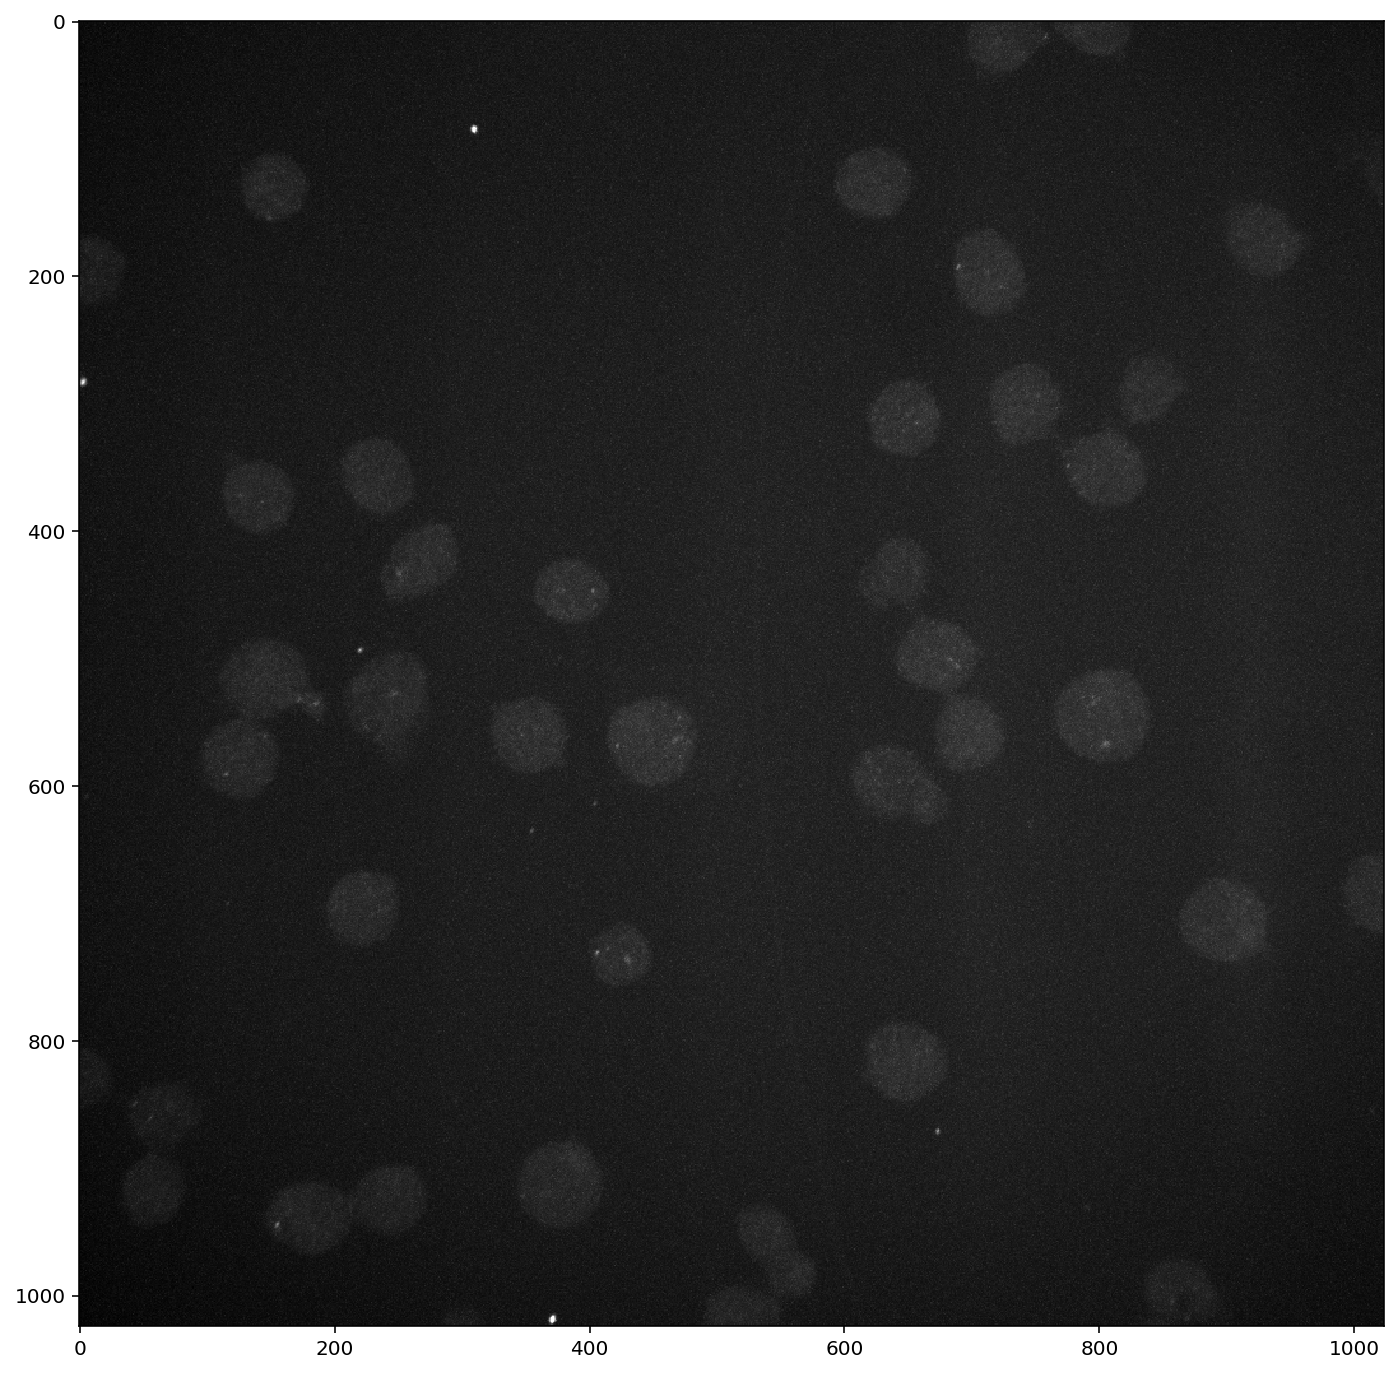

In [4]:
# Select only Atto647N channel (2nd channel) and create max projection
img_atto = img[1]
atto_max = np.max(img_atto, axis=0)

# Visualize max projection
plt.figure(figsize=(12,12))
plt.imshow(atto_max, vmax=1000, cmap='gray')

In [5]:
# Detect spots with Laplacian of Gaussian (LoG)
# It is recommended to check first how many spots have been detected, as showing the plot might take too long

# NOTE: vary the threshold parameter to detect less or more spots
blobs_log = blob_log(atto_max, max_sigma=5, num_sigma=10, threshold=30)

# Compute radii in the 3rd column (sigma with maximal response)
# NOTE: the constant size factor of sqrt(2 * ln(2)) gives the radius at half the "height" of the spot
# by multiplying it with 2, you would get the full-width-at-half-maximum (FWHM)
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2 * np.log(2))

# number of spots
print(len(blobs_log))

34


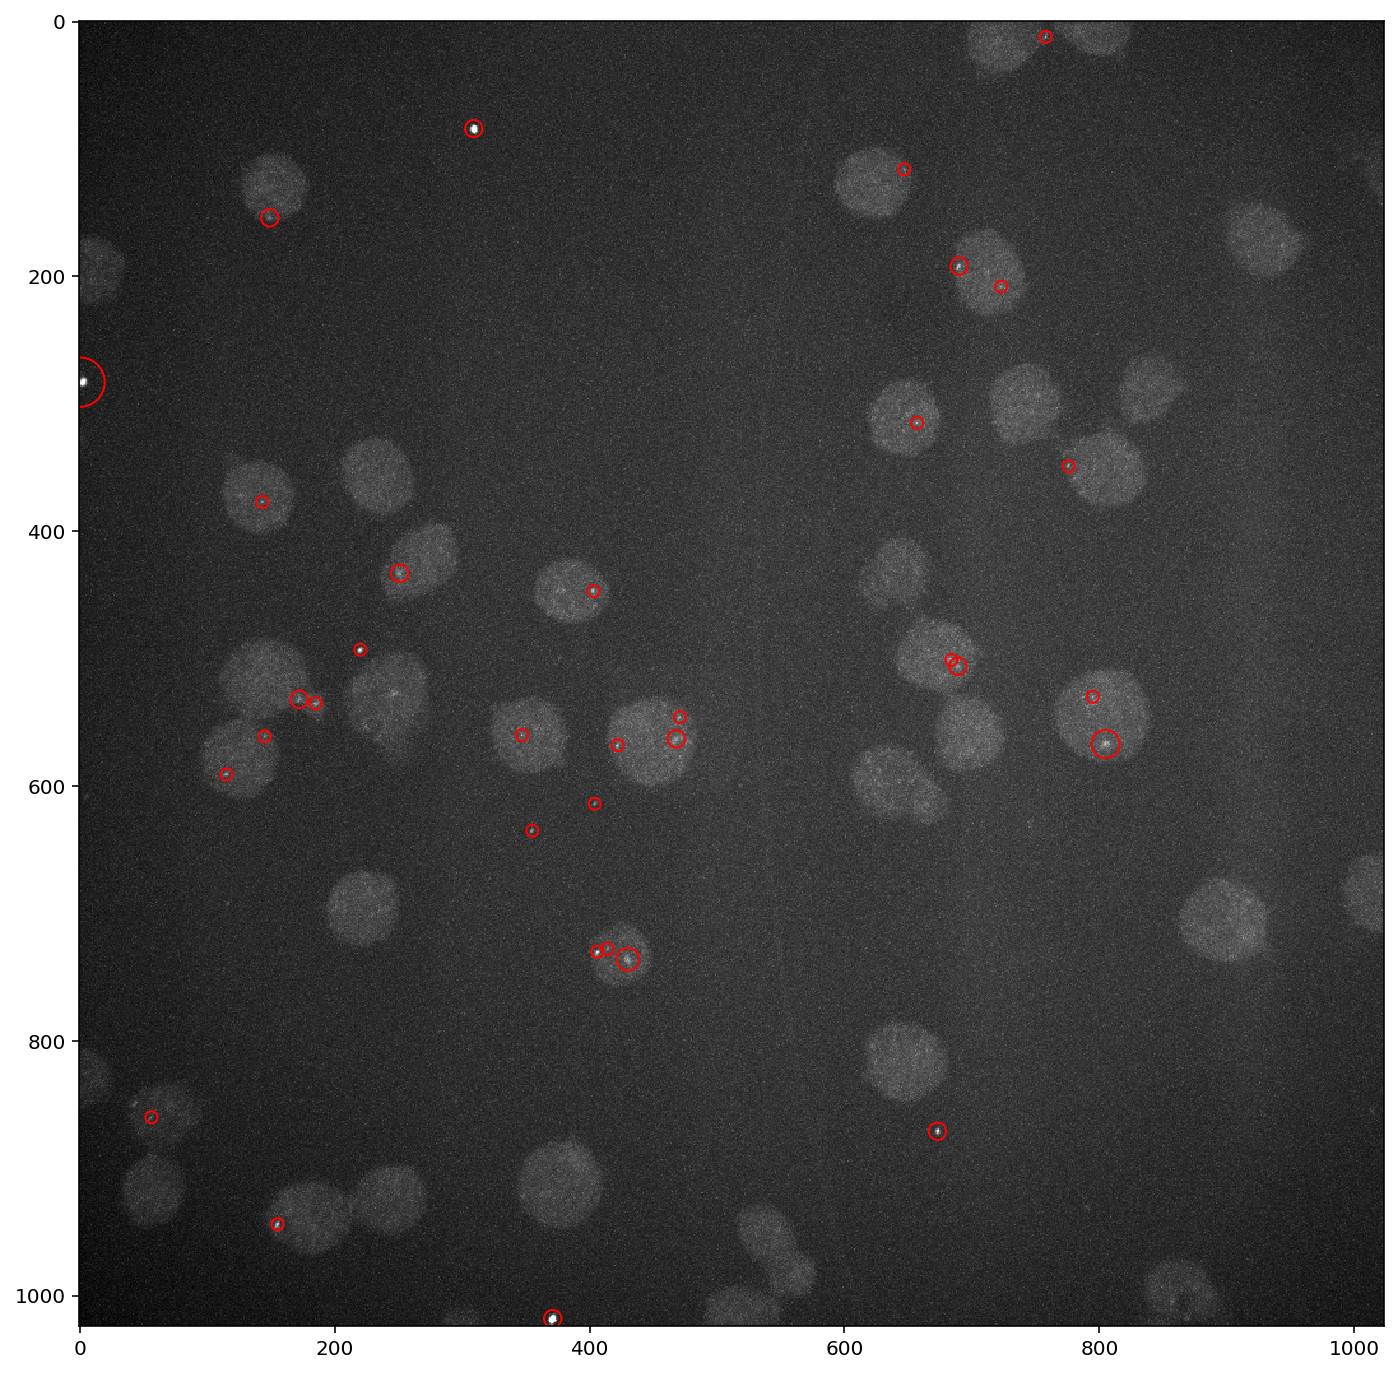

In [6]:
radius_expansion = 4
# Add detected spots to the figure
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(atto_max,vmax=800, cmap='gray')
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r*radius_expansion, color='red', linewidth=1, fill=False) # increased circle radius by 4
    ax.add_patch(c)

In [7]:
from skimage.filters import threshold_li
from skimage.morphology import remove_small_objects

# get dapi image, segment via thresholding
img_dapi = img[0]
t = threshold_li(img_dapi)
dapi_mask = img_dapi > t
dapi_mask = remove_small_objects(dapi_mask, 1000)

in_nucleus = []
for y,x,s in blobs_log:

    # get intensities at this xy point along z, find maximum, check if in dapi mask
    z_intensities = img_atto[:, int(y), int(x)]
    z = np.argmax(z_intensities)
    in_nucleus.append(dapi_mask[int(z), int(y), int(x)])

# only keep blobs that are in nucleus
blobs_log = blobs_log[in_nucleus]

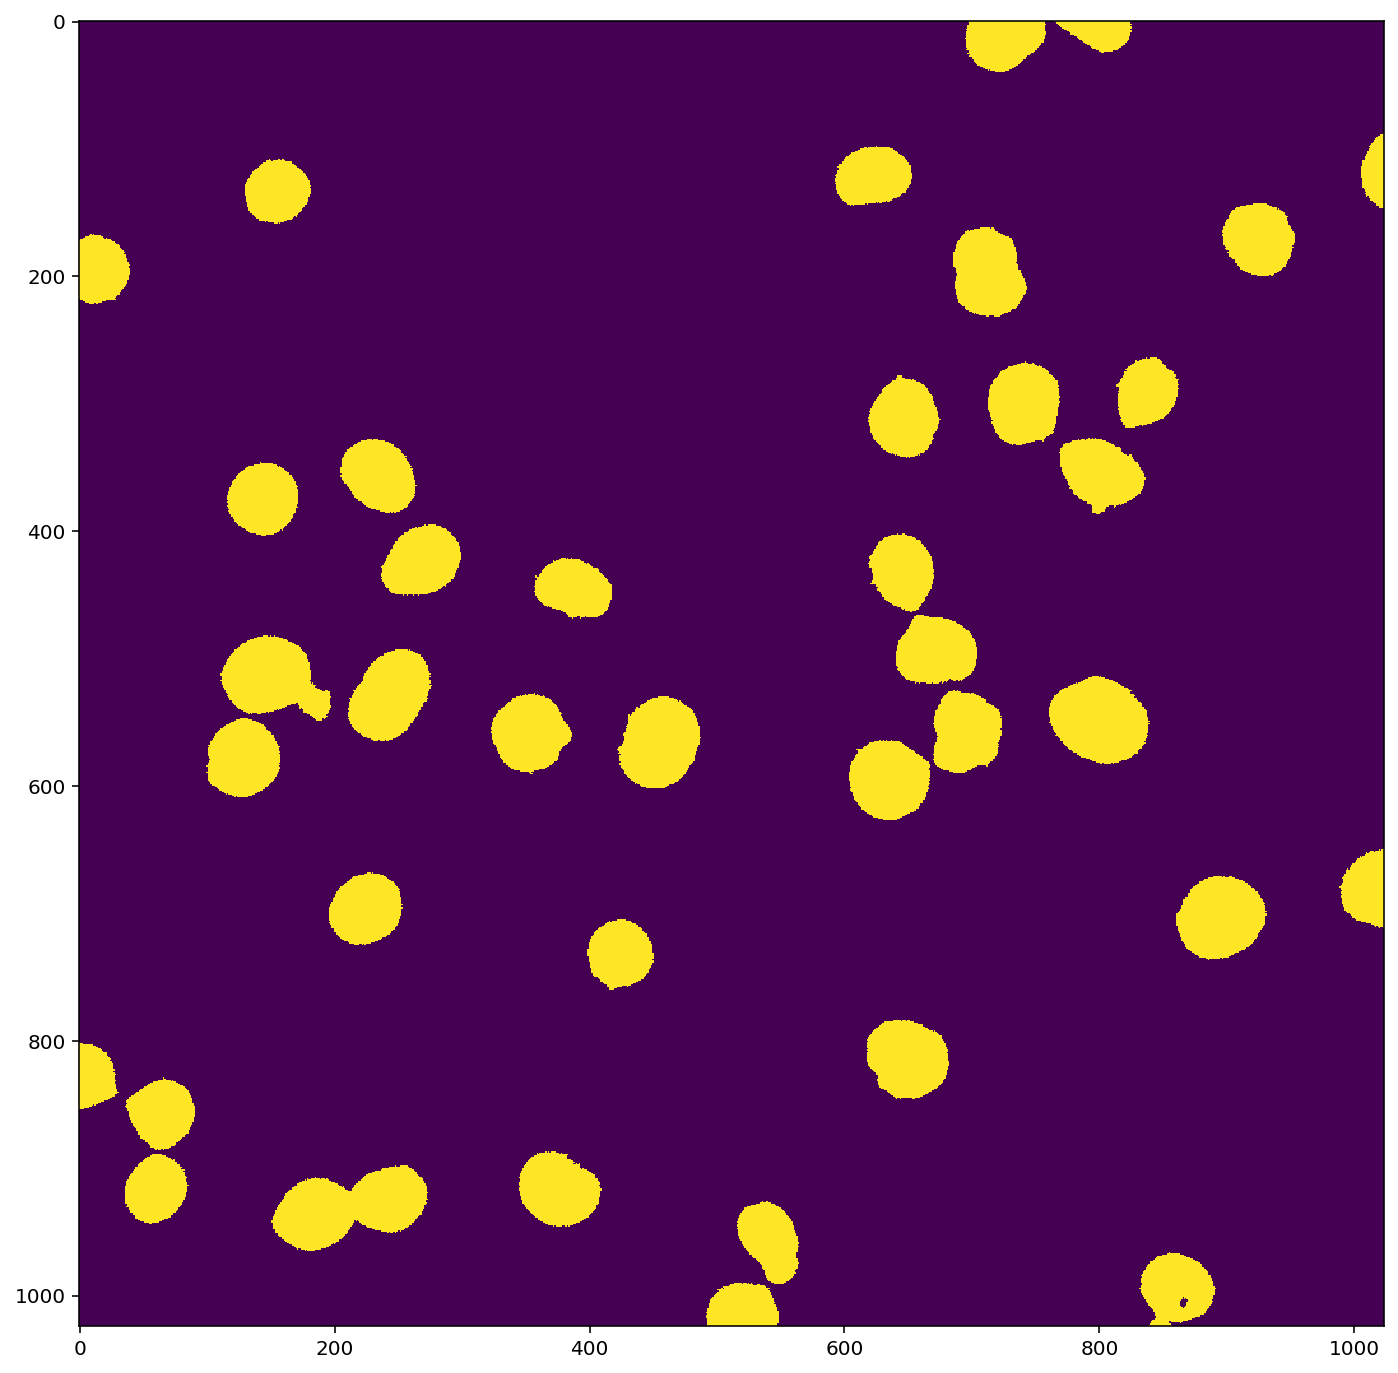

In [8]:
plt.figure(figsize=(12,12))
plt.imshow(dapi_mask.max(axis=0))

In [9]:
# plt.figure(figsize=(12,12))
# plt.imshow(dapi_mask.max(axis=0))
# plt.axis('off')
# plt.savefig("dapi_mask.png", bbox_inches='tight')

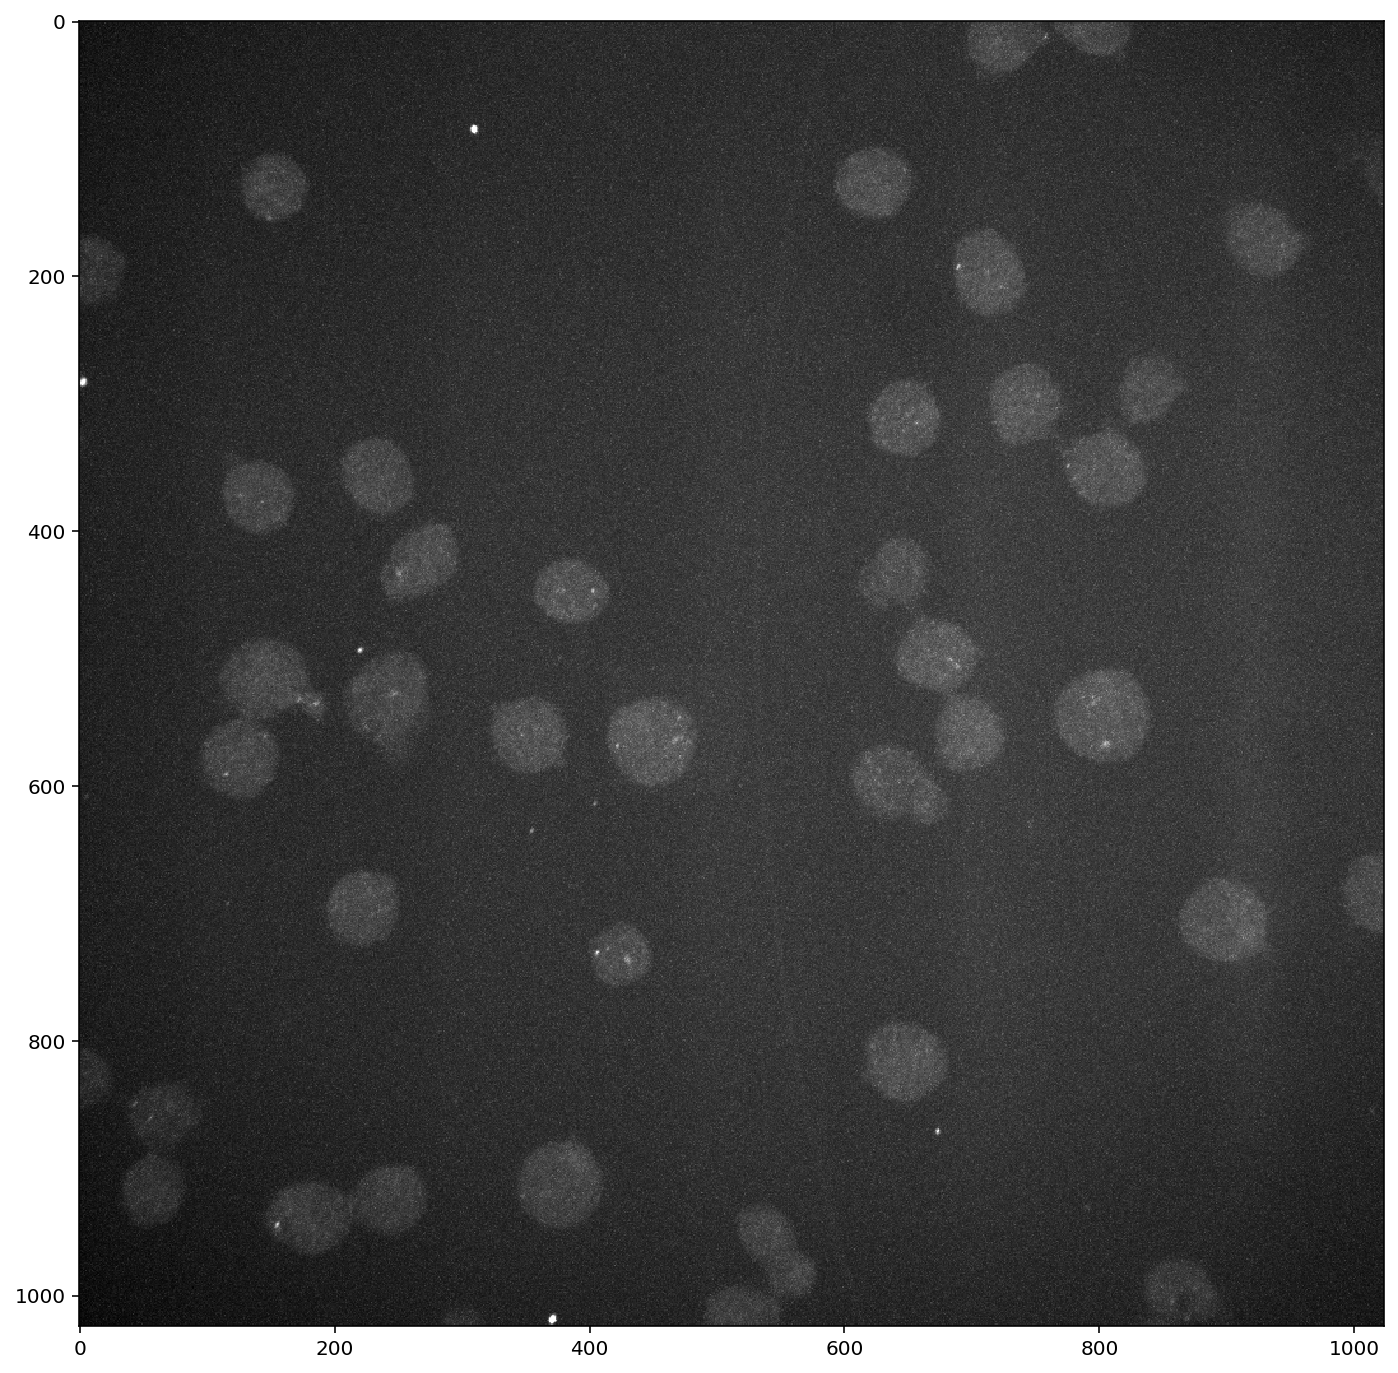

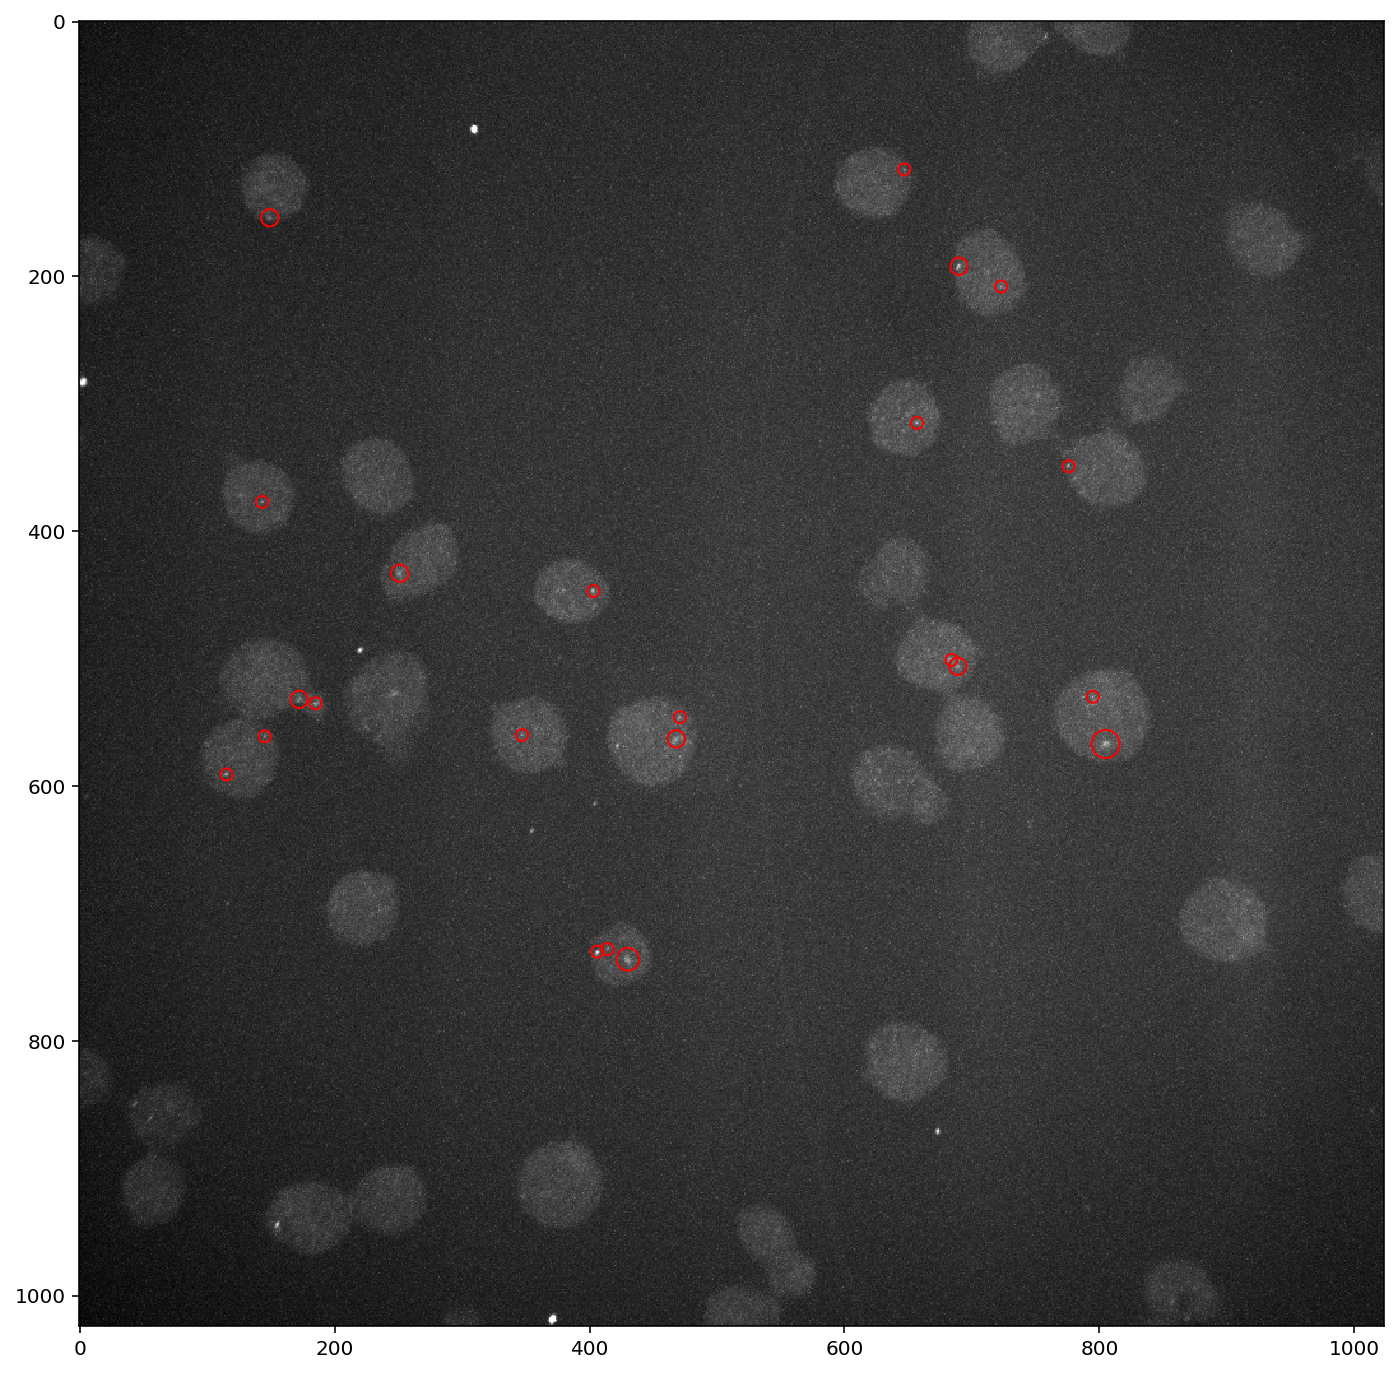

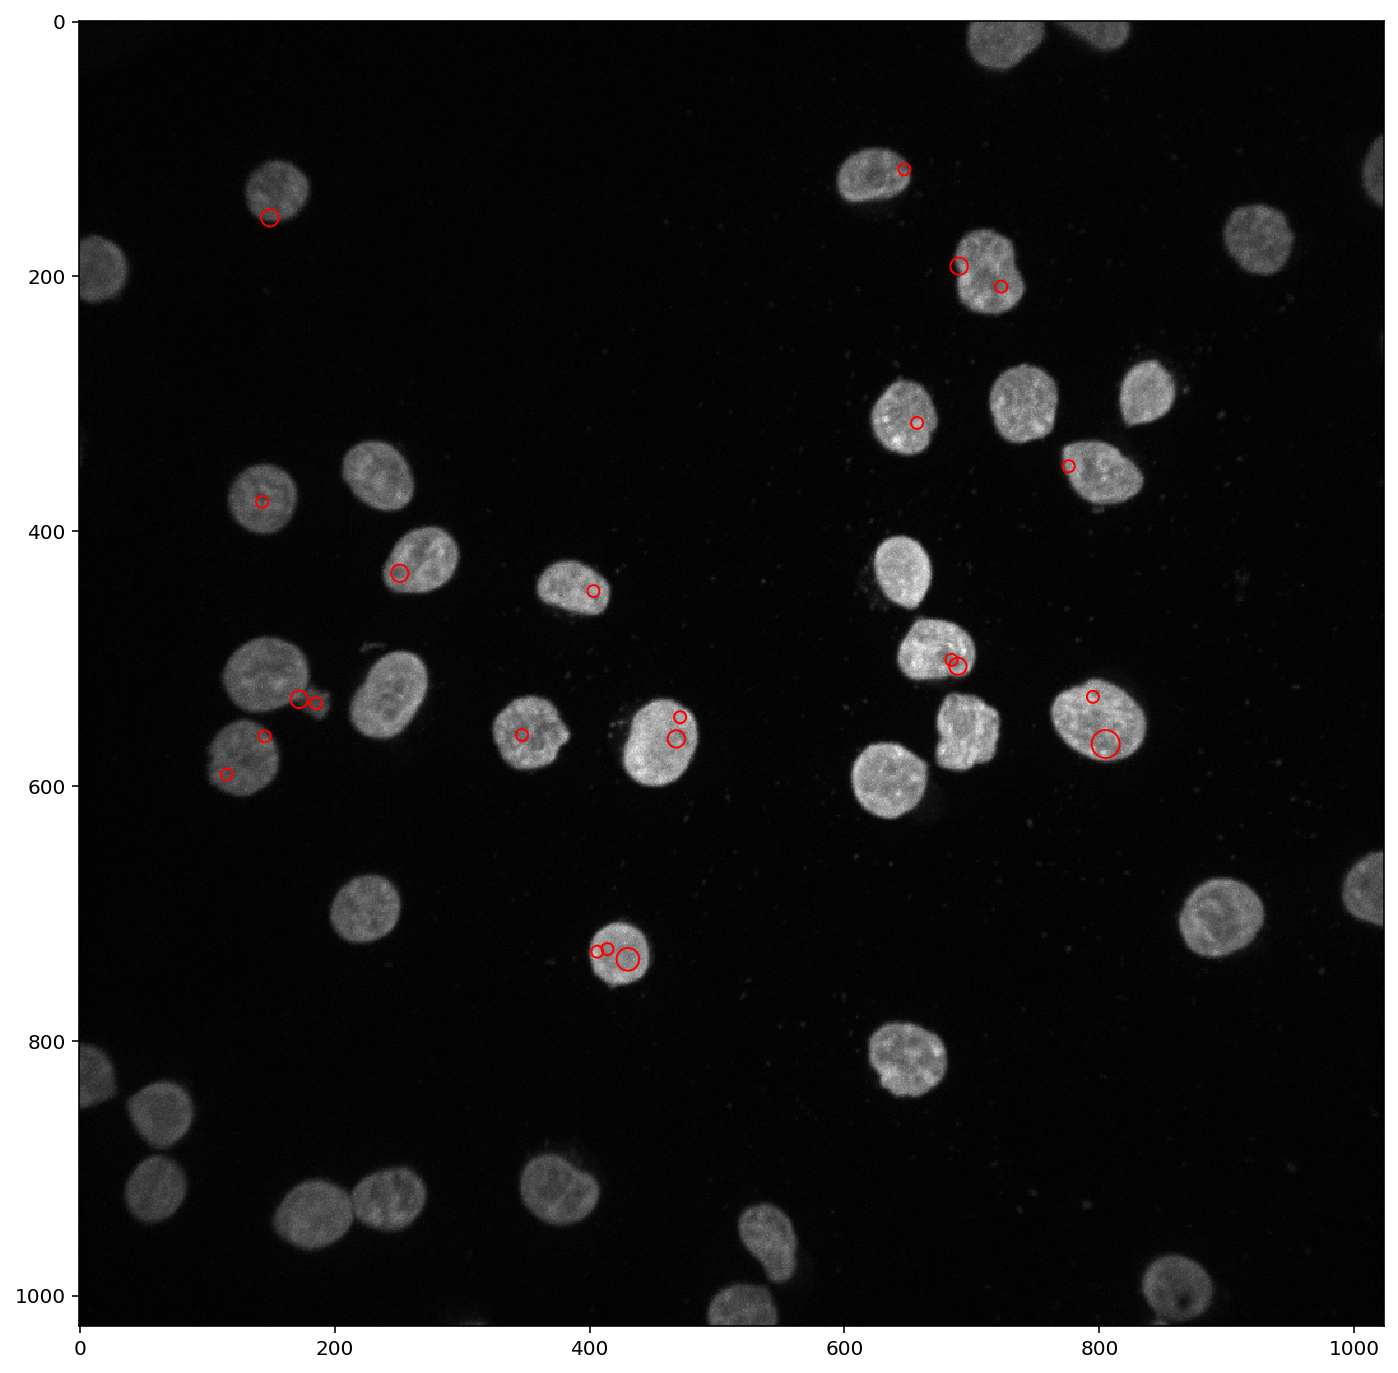

In [10]:
# expand circles in plot so we see the spots in the middle more clearly
radius_expansion = 4

# Show image before and after spot detection
plt.figure(figsize=(12,12))
plt.imshow(atto_max, vmax=800, cmap='gray')

# Add detected spots to the figure
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(atto_max, vmax=800, cmap='gray')
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r*radius_expansion, color='red', linewidth=1, fill=False) # increased circle radius by 4
    ax.add_patch(c)

# plot spots on top of DAPI
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(img_dapi.max(axis=0), cmap='gray')
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r*radius_expansion, color='red', linewidth=1, fill=False) # increased circle radius by 4
    ax.add_patch(c)

# Background Correction

In [11]:
from skimage import restoration
from scipy import ndimage as ndi

def smoothed_background(img, r=100, smooth=True):
    # estimate background with (optional) smooting

    # smooth like ImageJ: https://imagej.nih.gov/ij/docs/menus/process.html#background
    if smooth:
        img = ndi.median_filter(ndi.maximum_filter(img, 3), 3)

    return restoration.rolling_ball(img, radius = r)

def subtract_background(img, r=100, smooth=True):

    if len(img.shape) == 2:
        background = smoothed_background(img, r, smooth)

    # do for each plane in 3d img (NOTE: can be very slow!)
    elif len(img.shape) == 3:
        background = np.zeros_like(img)
        for i in range(img.shape[0]):
            background[i] = smoothed_background(img[i], r, smooth)

    else:
        raise ValueError('image neither 2D nor 3D')

    return img-background

# Detect Spots & create df

In [12]:
combined_df = pd.DataFrame()

# NOTE: img_files[:-2] leaves the last two images out - they had strange "smears" -> lots of erroneous spots
for img_file in img_files[:-2]:
    # Load image
    with ND2Reader(img_file) as reader:
        reader.bundle_axes = 'czyx'
        img = np.array(reader[0])

    # Select only Atto647N channel and create max projection
    img_atto = img[1]
    atto_max = np.max(img_atto, axis=0)
    
    # Detect spots with Laplacian of Gaussian (LoG)
    blobs_log = blob_log(atto_max, max_sigma=5, num_sigma=10, threshold=30) # NOTE: lowered threshold to 30
    blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2 * np.log(2))
    
    # Get dapi image, segment via thresholding
    img_dapi = img[0]
    t = threshold_li(img_dapi)
    dapi_mask = img_dapi > t
    dapi_mask = remove_small_objects(dapi_mask)
    
    in_nucleus = []
    for y,x,s in blobs_log:

        # Get intensities at this xy point along z, find maximum, check if in dapi mask
        z_intensities = img_atto[:, int(y), int(x)]
        z = np.argmax(z_intensities)
        in_nucleus.append(dapi_mask[int(z), int(y), int(x)])

    # Only keep blobs that are in nucleus
    blobs_log = blobs_log[in_nucleus]

    # Background correction
    atto_max_subbg = subtract_background(atto_max)
    
    # Make df of spots intensity and fwhm
    intensities = []
    for y, x, r in blobs_log:
        intensities.append(atto_max_subbg[int(y), int(x)])
    df = pd.DataFrame()
    df['intensity'] = intensities
    df['fwhm'] = blobs_log[:,2] * 2
    df['file'] = img_file

    # NOTE: we add the volume of the cell for every spot here
    df['cells_volume'] = dapi_mask.sum()
    
    # Concatenate to combined_df
    combined_df = pd.concat([combined_df, df])

/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


/usr/local/lib/python3.8/dist-packages/nd2reader/raw_metadata.py:187: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


In [13]:
combined_df

intensity      fwhm                                               file  \
0   665.762596  2.354820  data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintS...   
1   503.605274  3.401407  data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintS...   
2   212.488219  4.447993  data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintS...   
3   180.442291  2.354820  data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintS...   
4   148.446320  2.354820  data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintS...   
..         ...       ...                                                ...   
7    94.076056  2.354820  data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintS...   
8   106.664368  2.354820  data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintS...   
9    70.306801  2.354820  data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintS...   
10   88.571217  2.354820  data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintS...   
11   92.454907  2.354820  data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintS...   

    cells_volume  
0        2400618  
1        2400618  
2        2400618  
3        2400618  
4        2400618  
..           ...  
7        5826249  
8        5826249  
9        5826249  
10       5826249  
11       5826249  

[232 rows x 4 columns]

In [14]:
combined_df = combined_df.reset_index(drop=True)
# combined_df.to_csv("./combined_df.csv", index=False)

In [15]:
def source(p):
    source=[]
    if 'Altius_CTRL' in p:
        source = 'Altius'
    if 'central_CTRL' in p:
        source = 'PaintShop central'
    if 'central_off' in p:
        source = 'PaintShop central+offset'
    return source

def has_fa(p):
    return 'overnight FA' if 'FA' in p else '1h FA'


In [16]:
combined_df['Source'] = combined_df['file'].apply(source)

combined_df['Formamide'] = combined_df['file'].apply(has_fa)

In [17]:
combined_df.to_csv("./combined_df_new.csv", index=False)

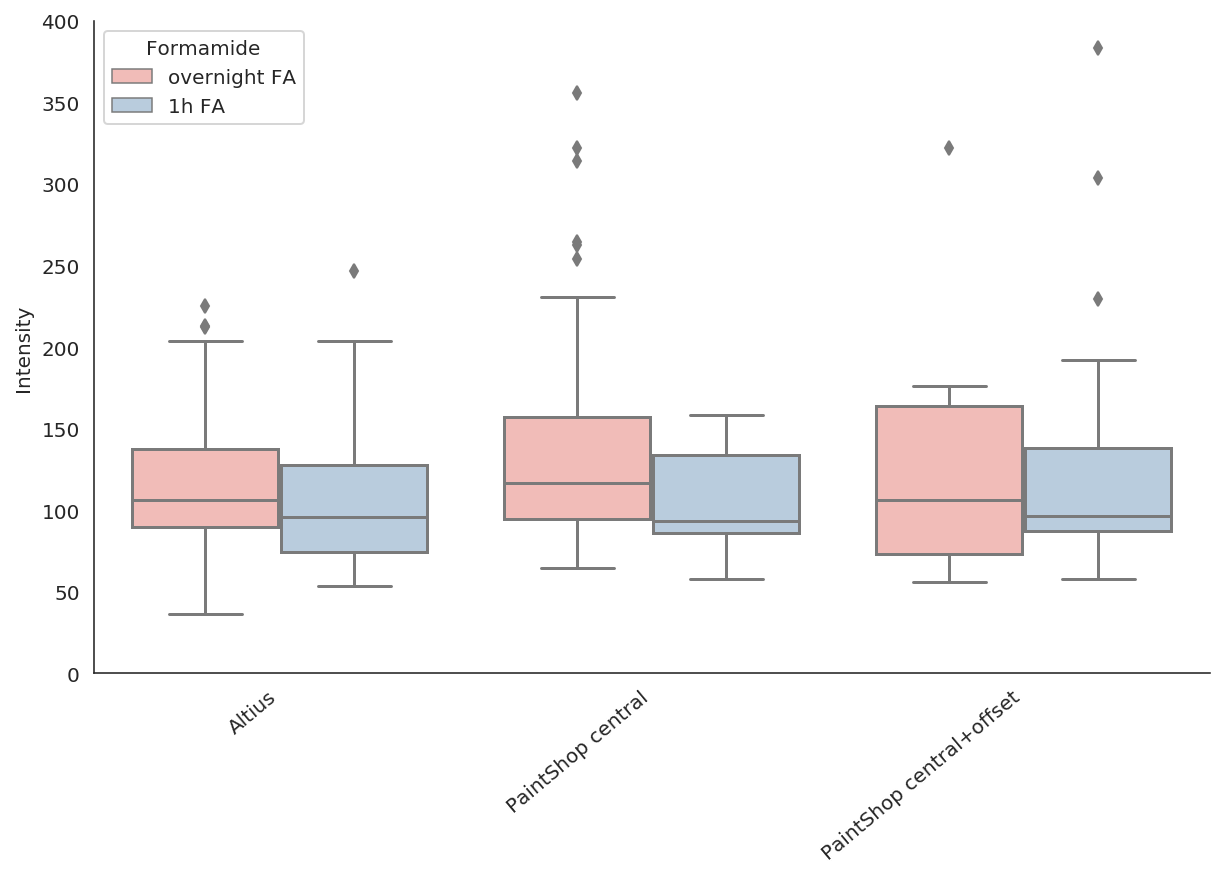

In [18]:
plt.figure(figsize = (10,6))
sns.set_style('white')
boxplot = sns.boxplot(x='Source', y='intensity', hue='Formamide', data=combined_df, palette='Pastel1',) #dodge=False)
boxplot.set_ylabel("Intensity")
boxplot.set(xlabel=None)
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=40, ha="right")
boxplot.set_ylim(0, 400)
sns.despine()
plt.show()

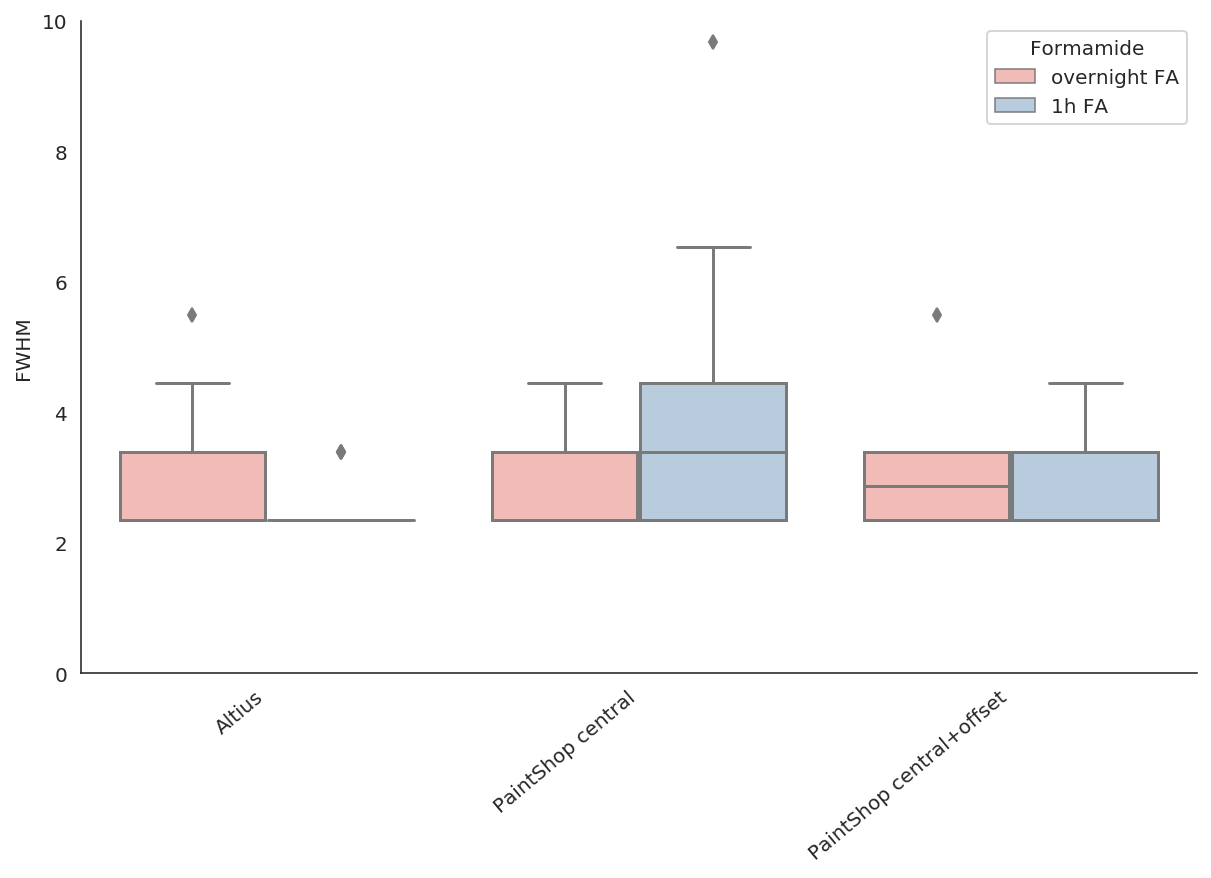

In [19]:
plt.figure(figsize = (10,6))
sns.set_style('white')
boxplot = sns.boxplot(x='Source', y='fwhm', hue='Formamide', data=combined_df, palette='Pastel1')# dodge=False)
boxplot.set_ylabel("FWHM")
boxplot.set(xlabel=None)
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=40, ha="right")
boxplot.set_ylim(0, 10)
sns.despine()
plt.show()

In [20]:
df_counts = combined_df.groupby('file')[['Source', 'Formamide']].describe()
df_counts

# NOTE: we get the mean value for cells volume, but the value is the same for all rows for one image
mean_volume = combined_df.groupby('file')['cells_volume'].describe()['mean']

# NOTE: the 10e6 multiplier gives us the number of spots per million pixels, instead of spots per pixel (very small number)
df_counts['normalized_count'] = df_counts[('Source','count')] * 10e6 / mean_volume

# NOTE: combine probe pool and formamide time into one column (for multitest below)
df_counts['combined_condition'] = df_counts[('Source','top')] + ', ' + df_counts[('Formamide','top')]
df_counts

Source         \
                                                    count unique   
file                                                               
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...     29      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...     23      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...     17      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...     22      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...      9      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...      7      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...     12      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...      7      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...     12      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...     17      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...     13      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...     10      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...     12      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...      6      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...      6      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...      1      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...      2      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...      1      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...      5      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...      2      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...      7      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...     12      1   

                                                                              \
                                                                         top   
file                                                                           
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...                    Altius   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...                    Altius   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...                    Altius   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...                    Altius   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...                    Altius   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...                    Altius   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...                    Altius   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...                    Altius   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...         PaintShop central   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...         PaintShop central   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...         PaintShop central   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...         PaintShop central   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...         PaintShop central   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...         PaintShop central   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...         PaintShop central   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...         PaintShop central   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...  PaintShop central+offset   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...  PaintShop central+offset   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...  PaintShop central+offset   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...  PaintShop central+offset   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...  PaintShop central+offset   
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...  PaintShop central+offset   

                                                        Formamide         \
                                                   freq     count unique   
file                                                                       
data/20221019_K562_EVI1-GFP_ctrl_Altius_PaintSh...   29        29      1   
data/20221019_K562_EVI1-GFP_ctrl_Altius_Paint

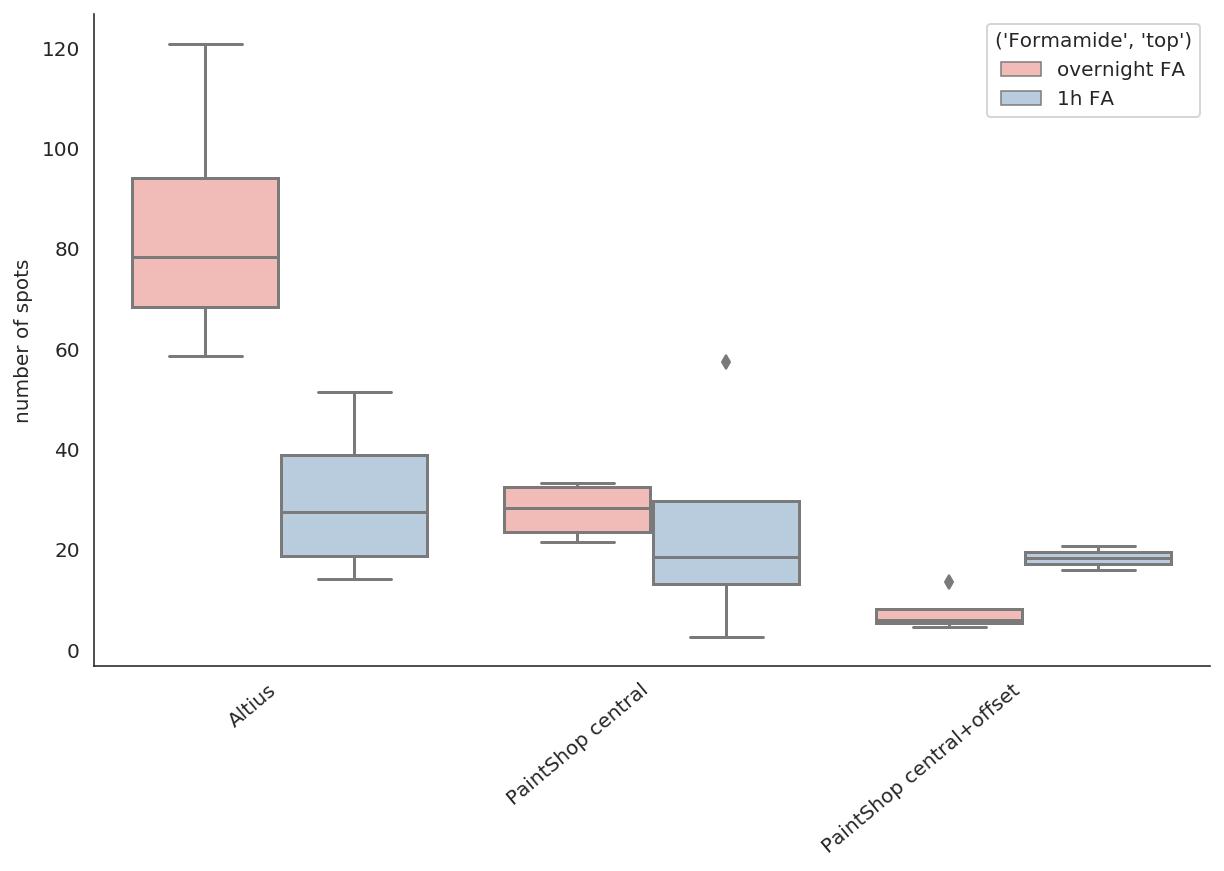

In [21]:
plt.figure(figsize = (10,6))
sns.set_style('white')
boxplot = sns.boxplot(x=('Source', 'top'), y='normalized_count', hue=('Formamide', 'top'), data=df_counts, palette='Pastel1')# dodge=False)
boxplot.set_ylabel("number of spots")
boxplot.set(xlabel=None)
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=40, ha="right")
# boxplot.set_ylim(0, 100)
sns.despine()
plt.show()

## Pairwise comparison with MultiComparison

In [22]:
# from scipy.stats import mannwhitneyu
# from statsmodels.stats.multicomp import MultiComparison

# # init multi comparison
# # freq has to be converted to int
# mc = MultiComparison(df_counts.normalized_count.astype(float), df_counts['combined_condition'])

# # do pairwise tests with MannWhitneyU, Holm correction
# res, _, _ = mc.allpairtest(mannwhitneyu, method='holm')

# # display results as table
# res

In [23]:
# ! pip3 list

## Old: multiple comparison by hand

In [24]:
# from scipy.stats import mannwhitneyu


# x = df_counts[df_counts.top == 'Paintshop central offset']['freq'].values.astype(int)
# y = df_counts[df_counts.top == 'Altius']['freq'].values.astype(int)

# mannwhitneyu(x, y)
# # x, y

In [25]:
# from itertools import combinations
# from statsmodels.stats.multitest import multipletests

# pvalues = []
# for k1, k2 in combinations(df_counts.top.unique(), 2):
#     x = df_counts[df_counts.top == k1]['freq'].values.astype(int)
#     y = df_counts[df_counts.top == k2]['freq'].values.astype(int)
#     pvalues.append(mannwhitneyu(x, y).pvalue)
# pvalues

# sig, pvalues_adj, _, _ = multipletests(pvalues)

# for k, s, pval in zip(combinations(df_counts.top.unique(), 2), sig, pvalues_adj):
#     print(f'{k}: {pval} {"*" if s else ""}')